# Training

In [1]:
import time

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from src.starcattovae.training.data import Data

from src.starcattovae.nn.vae import VAE
from src.starcattovae.nn.cvae import CVAE
from src.starcattovae.nn.cvae import Encoder, Decoder, Q

In [5]:
from src.starcattovae.plotting import plot_loss
from src.starcattovae.plotting import plot_individual_loss
from src.starcattovae.plotting import plot_training_validation_loss
from src.starcattovae.plotting import plot_reconstruction
from src.starcattovae.plotting import plot_waveform_grid
from src.starcattovae.plotting import plot_latent_morphs
from src.starcattovae.plotting import animate_latent_morphs
from src.starcattovae.plotting import plot_signal_distribution
from src.starcattovae.plotting import plot_single_signal

In [6]:
manualSeed = 99
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # reproducibility

### Define Parameters

In [7]:
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Using device: {DEVICE}")

# model parameters
batch_size = 32
epochs = 256 # need to change this to max epochs so we have early stopping

signal_dim = 256
modes = 32
hidden_dim = 512
latent_dim = 8
lr = 1e-4

multi_param = False

if multi_param:
    param_dim = 27
else:
    param_dim = 1

Using device: mps


## Load Training Data

In [8]:
np.random.seed(42)
indices = np.arange(1684) # this is the number of signals minus all the signals with beta_IC_b less than 0
np.random.shuffle(indices)
split_ratio = 0.9
split_idx = int(len(indices) * split_ratio)
train_indices = indices[:split_idx]
validation_indices = indices[split_idx:]

# Create train and validation datasets
train_dataset = Data(indices=train_indices, train=True, multi_param=multi_param)
validation_dataset = Data(indices=validation_indices, train=False, multi_param=multi_param)

# Check for overlap
train_indices_set = set(train_dataset.get_indices())
validation_indices_set = set(validation_dataset.get_indices())

overlap = train_indices_set.intersection(validation_indices_set)
if len(overlap) == 0:
    print("Train and validation sets are different.")
else:
    print("Train and validation sets have overlap.")

Train and validation sets are different.


In [9]:
train_dataset.summary()
validation_dataset.summary()

2025-05-01 00:25:21.670 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.524 +/- 39.879
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 656.2575073242188
Signal Dataset shape: (256, 1515)
Parameter Dataset shape: (1515, 1)

2025-05-01 00:25:21.671 | INFO     | src.starcattovae.training.data:summary:118 - Signal Dataset mean: -0.444 +/- 38.309
Signal Dataset scaling factor (to match noise in generator): 5
Signal Dataset max value: 626.9296875
Signal Dataset shape: (256, 169)
Parameter Dataset shape: (169, 1)



In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [11]:
for batch in train_dataloader:  # train_dataloader is the DataLoader object
    data_example, param = batch  # Unpack batch
    data_shape = data_example.shape
    condition_dim = param.shape[1] if len(param.shape) > 1 else 1  # Assuming batch first

    print(f"Data shape: {data_shape}")
    print(f"Parameter shape: {param.shape}")
    print(f"Parameter example: {param[0]}")
    break  # Only process the first batch

Data shape: torch.Size([32, 1, 256])
Parameter shape: torch.Size([32, 1, 1])
Parameter example: tensor([[0.1741]])


## Load VAE

In [12]:
cvae = CVAE(latent_dim=latent_dim, hidden_dim=hidden_dim, param_dim=param_dim, signal_dim=signal_dim, num_components=modes, num_epochs=epochs, DEVICE=DEVICE).to(DEVICE)

### Optimiser

In [13]:
optimizer = Adam(cvae.parameters(), lr=lr)

### Train VAE

#### CVAE Training

Start training CVAE...


Training:   0%|          | 1/256 [00:02<12:02,  2.84s/it]

Epoch 1, Train Loss: 0.2525
Epoch 1, Train Reproduction Loss: -0.2475
Epoch 1, Train KLD Loss: 0.0050


Training:   1%|          | 2/256 [00:04<10:11,  2.41s/it]

Epoch 2, Train Loss: -1.1416
Epoch 2, Train Reproduction Loss: 1.1424
Epoch 2, Train KLD Loss: 0.0008


Training:   1%|          | 3/256 [00:07<09:29,  2.25s/it]

Epoch 3, Train Loss: -1.2489
Epoch 3, Train Reproduction Loss: 1.2490
Epoch 3, Train KLD Loss: 0.0001


Training:   2%|▏         | 4/256 [00:09<09:10,  2.18s/it]

Epoch 4, Train Loss: -1.2792
Epoch 4, Train Reproduction Loss: 1.2793
Epoch 4, Train KLD Loss: 0.0000
Epoch 5, Train Loss: -1.2371
Epoch 5, Train Reproduction Loss: 1.2371
Epoch 5, Train KLD Loss: 0.0000


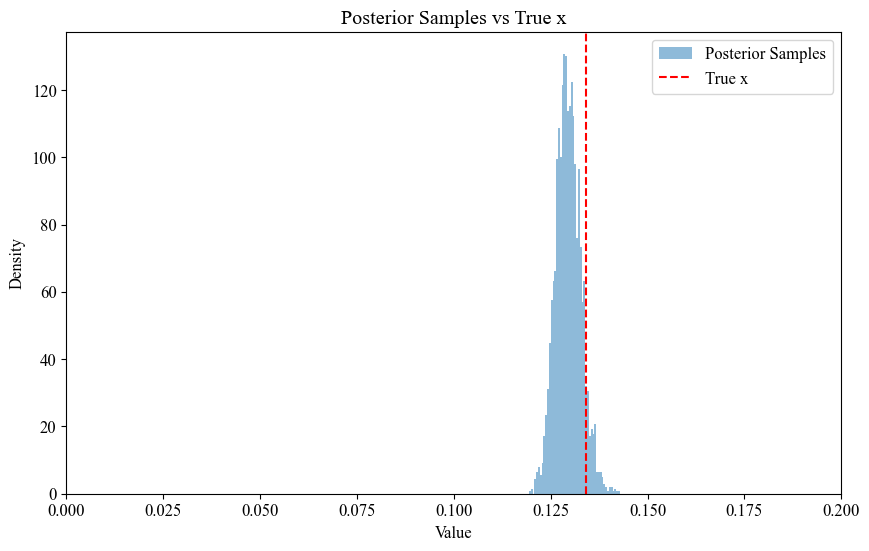

Training:   2%|▏         | 6/256 [00:21<17:05,  4.10s/it]

Epoch 6, Train Loss: -1.2414
Epoch 6, Train Reproduction Loss: 1.2414
Epoch 6, Train KLD Loss: 0.0000


Training:   3%|▎         | 7/256 [00:23<14:15,  3.43s/it]

Epoch 7, Train Loss: -1.3017
Epoch 7, Train Reproduction Loss: 1.3017
Epoch 7, Train KLD Loss: 0.0000


Training:   3%|▎         | 8/256 [00:25<12:31,  3.03s/it]

Epoch 8, Train Loss: -1.2306
Epoch 8, Train Reproduction Loss: 1.2306
Epoch 8, Train KLD Loss: 0.0000


Training:   4%|▎         | 9/256 [00:27<11:27,  2.78s/it]

Epoch 9, Train Loss: -1.2974
Epoch 9, Train Reproduction Loss: 1.2974
Epoch 9, Train KLD Loss: 0.0000
Epoch 10, Train Loss: -1.2772
Epoch 10, Train Reproduction Loss: 1.2772
Epoch 10, Train KLD Loss: 0.0000


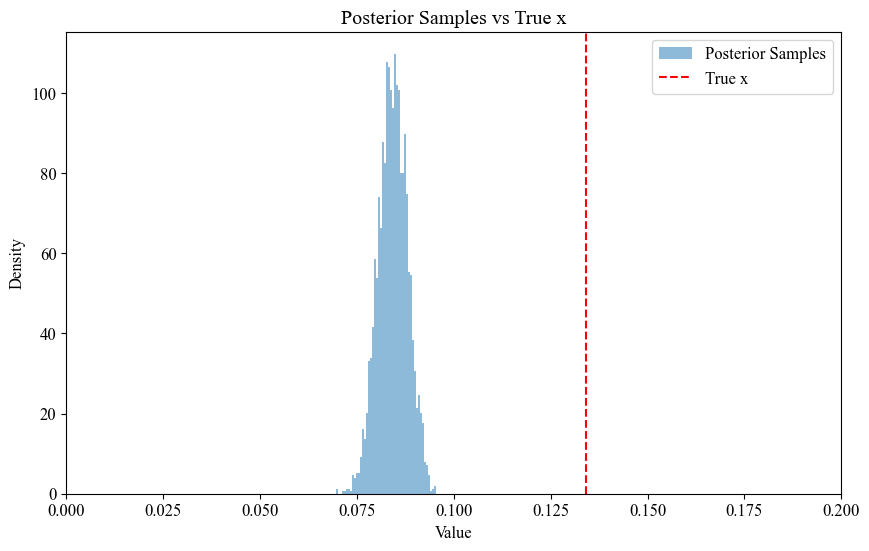

Training:   4%|▍         | 11/256 [00:39<16:27,  4.03s/it]

Epoch 11, Train Loss: -1.3068
Epoch 11, Train Reproduction Loss: 1.3068
Epoch 11, Train KLD Loss: 0.0000


Training:   5%|▍         | 12/256 [00:41<13:57,  3.43s/it]

Epoch 12, Train Loss: -1.2936
Epoch 12, Train Reproduction Loss: 1.2936
Epoch 12, Train KLD Loss: 0.0000


Training:   5%|▌         | 13/256 [00:43<12:09,  3.00s/it]

Epoch 13, Train Loss: -1.2706
Epoch 13, Train Reproduction Loss: 1.2706
Epoch 13, Train KLD Loss: 0.0000


Training:   5%|▌         | 14/256 [00:45<11:01,  2.73s/it]

Epoch 14, Train Loss: -1.2952
Epoch 14, Train Reproduction Loss: 1.2952
Epoch 14, Train KLD Loss: 0.0000
Epoch 15, Train Loss: -1.2589
Epoch 15, Train Reproduction Loss: 1.2589
Epoch 15, Train KLD Loss: 0.0000


In [ ]:
print("Start training CVAE...")
avg_total_losses = []
avg_reproduction_losses = []
avg_kld_losses = []

avg_total_losses_validation = []
avg_reproduction_losses_validation = []
avg_kld_losses_validation = []


# validation data for validation
validation_y = []
validation_x = []
for y_validation, x_validation in validation_dataloader:
    validation_y.append(y_validation.to(DEVICE))
    validation_x.append(x_validation.to(DEVICE))

validation_y = torch.cat(validation_y, dim=0)
validation_x = torch.cat(validation_x, dim=0)


for epoch in tqdm(range(epochs), desc="Training"):
    overall_total_loss = 0
    overall_reproduction_loss = 0
    overall_kld_loss = 0

    overall_total_loss_validation = 0
    overall_reproduction_loss_validation = 0
    overall_kld_loss_validation = 0

    total_samples = 0

    for batch_idx, (y, x) in enumerate(train_dataloader, 0):
        cvae.train()
        y = y.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        y = y.to(DEVICE)
        # reshape to (batch_size, 1) if needed
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 256) if needed
        x = x.to(DEVICE)

        optimizer.zero_grad()
        r2_x_mean, total_loss, recontruction_loss_x, KLD = cvae.forward(x, y, epoch)
        
        overall_total_loss += total_loss.item()
        overall_reproduction_loss += recontruction_loss_x.item()
        overall_kld_loss += KLD.item()
        total_samples += x.size(0)

        total_loss.backward()
        optimizer.step()

        # validation losses
        cvae.eval()
        # with torch.no_grad():
            # x_validation = validation_data
            # y_validation = validation_conditions
            # x_validation = x_validation.view(x_validation.size(0), -1).to(DEVICE)
            # x_hat_validation, mean_validation, log_var_validation = model(x_validation, y_validation)
            # total_loss_validation, reproduction_loss_validation, kld_loss_validation = loss_function(x_validation, x_hat_validation, mean_validation, log_var_validation)

    # summarise training losses
    avg_total_loss = overall_total_loss / total_samples
    print(f"Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}")
    avg_reproduction_loss = overall_reproduction_loss / total_samples
    print(f"Epoch {epoch+1}, Train Reproduction Loss: {avg_reproduction_loss:.4f}")
    avg_kld_loss = overall_kld_loss / total_samples
    print(f"Epoch {epoch+1}, Train KLD Loss: {avg_kld_loss:.4f}")
    
    avg_total_losses.append(avg_total_loss)
    avg_reproduction_losses.append(avg_reproduction_loss)
    avg_kld_losses.append(avg_kld_loss)

    # summarise validation losses
    # avg_total_loss_validation = total_loss_validation.item() / x_validation.size(0)
    # avg_reproduction_loss_validation = reproduction_loss_validation.item() / x_validation.size(0)
    # avg_kld_loss_validation = kld_loss_validation.item() / x_validation.size(0)

    # avg_total_losses_validation.append(avg_total_loss_validation)
    # avg_reproduction_losses_validation.append(avg_reproduction_loss_validation)
    # avg_kld_losses_validation.append(avg_kld_loss_validation)

    # tqdm.write(f'Epoch {epoch+1}, Train Loss: {avg_total_loss:.4f}, Val Loss: {avg_total_loss_validation:.4f}')

    if (epoch + 1) % 5 == 0:
    #     x = x.cpu().detach()
    #     x_hat = x_hat.cpu().detach()
    #     plot_reconstruction(x[0], x_hat[0], max_value=train_dataset.max_value)

    #     with torch.no_grad():
    #         generated_signals = model.decoder(noise, condition_noise).cpu().detach().numpy()
        
    #     plot_waveform_grid(signals=generated_signals, max_value=train_dataset.max_value)

    #     idx1 = torch.randint(0, x.size(0), (1,)).item()
    #     idx2 = idx1

    #     while idx2 == idx1: # ensures we don't sample the same signal
    #         idx2 = torch.randint(0, x.size(0), (1,)).item()

    #     signal_1 = x[idx1].to(DEVICE)
    #     signal_2 = x[idx2].to(DEVICE)
    #     condition_1 = y[idx1].to(DEVICE)
    #     condition_2 = y[idx2].to(DEVICE)
        
    #     plot_latent_morphs(model_conditional, signal_1, signal_2, max_value=train_dataset.max_value, steps=8)

        # posterior test samples
        with torch.no_grad():
            x_samples = cvae.posterior_samples(validation_y[0], 3000)

        # Plot histogram of posterior samples
        plt.figure(figsize=(10, 6))
        plt.hist(x_samples.cpu().numpy(), bins=50, alpha=0.5, label='Posterior Samples', density=True)

        # Add a vertical line for the true value
        true_value = validation_x[0].cpu().numpy()
        plt.axvline(true_value, color='red', linestyle='--', label='True x')
        plt.xlim(0, 0.2)
        plt.title('Posterior Samples vs True x')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.show()

print("Training finished!")
cvae.eval()

### Training and Validation Loss

In [ ]:
plot_training_validation_loss(avg_total_losses, avg_total_losses_validation)

In [ ]:
plot_individual_loss(avg_total_losses, avg_reproduction_losses, avg_kld_losses)

### Generated XXXXX Signals

In [ ]:
number_of_signals = 10000
noise = torch.randn(number_of_signals, latent_dim).to(DEVICE)

start_time = time.time()
with torch.no_grad():
    generated_signals = model.decoder(noise).cpu().detach().numpy()
end_time = time.time()

execution_time = end_time - start_time
print("Execution Time:", execution_time, "seconds")

In [ ]:
# generated_signals_transpose = np.empty((x_length, 0))

for i in range(number_of_signals):
    y = generated_signals[i, :].flatten()
    y = y * train_dataset.max_value
    y = y.reshape(-1, 1)
    
    generated_signals_transpose = np.concatenate((generated_signals_transpose, y), axis=1)

# save_path = "../generated_signals.csv"
np.savetxt(save_path, generated_signals_transpose, delimiter=",")

### Plot Generated Distribution

In [ ]:
plot_signal_distribution(generated_signals_transpose, generated=True)

### Morph Animation

In [ ]:
# select signals here

# plot and save animations
signal_1 = x[0].to(DEVICE)
signal_2 = x[7].to(DEVICE)
# animate_latent_morphs(model, signal_1, signal_2, train_dataset.max_value, train_dataset, steps=100, interval=200, save_path="latent_morph_animation_3.gif")